In [25]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.control import ConstControl
from pandapower.timeseries import DFData, OutputWriter, run_timeseries
import matplotlib.pyplot as plt
from scipy.stats import norm


## Power Network 

In [3]:
# Create PandaPower network (30bus) /(180 bus)
net = pn.case30()
# View all generator (gen) information and slack bus
gen_info = net.gen
print(gen_info)
print(net.ext_grid)
# Print the bus number where the generator is located
pv_bus_numbers = net.gen['bus'].values
print("Generator (PV) bus numbers:", pv_bus_numbers)

# Identify the 5 PV buses in the IEEE 30-bus system
pv_buses = [1, 21, 26, 22, 12]

   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  60.97    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  21.59    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  26.91    1.0     NaN       -15.0        48.7      1.0  False   
3  None   22  19.20    1.0     NaN       -10.0        40.0      1.0  False   
4  None   12  37.00    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
1        True           0.0  None          True      50.0       0.0  
2        True           0.0  None          True      55.0       0.0  
3        True           0.0  None          True      30.0       0.0  
4        True           0.0  None          True      40.0       0.0  
   name  bus  vm_pu  va_degree  slack_weight  in_service  max_p_mw  min_p_mw  \
0  None    0    1.0        0.0 

In [4]:
# View the bus information of the external power grid (Slack bus)
slack_bus_numbers = net.ext_grid['bus'].values
print("Slack bus numbers:", slack_bus_numbers)

# View load information
print(net.load)

# Calculate total active power and reactive power
total_p = net.load['p_mw'].sum()  # Total active power
total_q = net.load['q_mvar'].sum()  # Total reactive power

print(f"Total active power load of IEEE 30-bus system: {total_p} MW")
print(f"Total reactive power load of IEEE 30-bus system: {total_q} MVar")

Slack bus numbers: [0]
    name  bus  p_mw  q_mvar  const_z_percent  const_i_percent  sn_mva  \
0   None    1  21.7    12.7              0.0              0.0     NaN   
1   None    2   2.4     1.2              0.0              0.0     NaN   
2   None    3   7.6     1.6              0.0              0.0     NaN   
3   None    6  22.8    10.9              0.0              0.0     NaN   
4   None    7  30.0    30.0              0.0              0.0     NaN   
5   None    9   5.8     2.0              0.0              0.0     NaN   
6   None   11  11.2     7.5              0.0              0.0     NaN   
7   None   13   6.2     1.6              0.0              0.0     NaN   
8   None   14   8.2     2.5              0.0              0.0     NaN   
9   None   15   3.5     1.8              0.0              0.0     NaN   
10  None   16   9.0     5.8              0.0              0.0     NaN   
11  None   17   3.2     0.9              0.0              0.0     NaN   
12  None   18   9.5     3.4 

In [5]:
# Initialize an empty list to store installed capacities of each generator
installed_capacities = []

# Loop through each row in the gen_info DataFrame to extract information
for i, row in gen_info.iterrows():
    bus_id = row['bus']  # Get the bus ID for the generator
    installed_capacity = row['max_p_mw']  # Get the installed capacity of the generator in MW
    print(f"Generator at Bus {bus_id}: Installed Capacity = {installed_capacity} MW")
    installed_capacities.append(installed_capacity)  # Append the capacity to the list

# Calculate the total installed capacity of all generators
total_installed_capacity = sum(installed_capacities)
print(f"Total Installed Capacity = {total_installed_capacity} MW")

# Create Static Generators (sgen) for the PV buses
for bus, installed_capacity in zip(pv_buses, installed_capacities):
    pp.create_sgen(net, bus, p_mw=0, max_p_mw=installed_capacity, name=f"PV_bus_{bus}")

# View all sgen information
sgen_info = net.sgen
print(sgen_info)

Generator at Bus 1: Installed Capacity = 80.0 MW
Generator at Bus 21: Installed Capacity = 50.0 MW
Generator at Bus 26: Installed Capacity = 55.0 MW
Generator at Bus 22: Installed Capacity = 30.0 MW
Generator at Bus 12: Installed Capacity = 40.0 MW
Total Installed Capacity = 255.0 MW
        name  bus  p_mw  q_mvar  sn_mva  scaling  in_service type  \
0   PV_bus_1    1   0.0     0.0     NaN      1.0        True  wye   
1  PV_bus_21   21   0.0     0.0     NaN      1.0        True  wye   
2  PV_bus_26   26   0.0     0.0     NaN      1.0        True  wye   
3  PV_bus_22   22   0.0     0.0     NaN      1.0        True  wye   
4  PV_bus_12   12   0.0     0.0     NaN      1.0        True  wye   

   current_source  max_p_mw  
0            True      80.0  
1            True      50.0  
2            True      55.0  
3            True      30.0  
4            True      40.0  


## Load data and Data processing

In [6]:
# Load the CSV file with ERCOT time-series data file
# file_path = 'C:\\Users\\default.DESKTOP-C4C7JDR\\Desktop\\ERCOT SOLAR DATA.xlsx'  # Home PC
file_path = 'C:\\Users\\jliu359\\OneDrive - Syracuse University\\Desktop\\ERCOT SOLAR DATA.xlsx' #Lab PC
ercot_data = pd.read_excel(file_path)
#  Read data
print(ercot_data.head())

# Extract the time and PV generation columns
# Set the time column as the index and ensure it's in datetime format
ercot_data['Time (Hour-Ending)'] = pd.to_datetime(ercot_data['Time (Hour-Ending)'])
ercot_data.set_index('Time (Hour-Ending)', inplace=True)
pv_generation = ercot_data['ERCOT.PVGR.GEN']

# Scale ERCOT's generation to match the total installed capacity of the 5 PV buses
scaling_factor = total_installed_capacity / 14249  # 14249 MW is the total solar installed capacity in the ERCOT dataset
scaled_pv_generation = pv_generation * scaling_factor

# Prepare a DataFrame to hold profiles for each PV bus with an integer index
profiles_df = pd.DataFrame(index=range(len(ercot_data)))

   Time (Hour-Ending)       Date    ERCOT.LOAD  ERCOT.PVGR.GEN  \
0 2023-01-01 01:00:00 2023-01-01  35829.306163        0.449746   
1 2023-01-01 02:00:00 2023-01-01  35245.390234        0.454733   
2 2023-01-01 03:00:00 2023-01-01  34599.761810        0.443528   
3 2023-01-01 04:00:00 2023-01-01  34227.151061        0.458567   
4 2023-01-01 05:00:00 2023-01-01  34093.414143        0.451126   

   Total Solar Installed, MW  Solar Output, % of Load  \
0                      14249                 0.001255   
1                      14249                 0.001290   
2                      14249                 0.001282   
3                      14249                 0.001340   
4                      14249                 0.001323   

   Solar Output, % of Installed  Solar 1-hr MW change  Solar 1-hr % change  \
0                      0.003156                   NaN                  NaN   
1                      0.003191                   0.0                  0.0   
2                      0.0

In [7]:
# Assign the scaled generation to the 5 PV buses as injected photovoltaic output based on their individual capacities
for i, bus in enumerate(pv_buses):
    # Calculate the proportion of generation for each PV bus
    bus_scaling_factor = installed_capacities[i] / total_installed_capacity
    bus_generation_profile = scaled_pv_generation * bus_scaling_factor

    # Add the generation profile to the DataFrame with a consistent column name
    column_name = f'bus_{bus}_p_mw'
    profiles_df[column_name] = bus_generation_profile.values

    # Create a DFData object with the profiles DataFrame
    data_source = DFData(profiles_df)

    # Create ConstControl objects for each PV bus to update active power over time
    for i, bus in enumerate(pv_buses):
        element_index = net.sgen[net.sgen['bus'] == bus].index[0]
        column_name = f'bus_{bus}_p_mw'
        ConstControl(net, element='sgen', variable='p_mw', element_index=element_index, data_source=data_source,
                     profile_name=column_name)

# Set up the output writer for results
# output_dir = "D:/My workspace/Results"#Home PC
output_dir = "C:/Apps-SU/My workspace/" #Lab PC
ow = OutputWriter(net, output_path=output_dir, output_file_type=".xlsx")
# Define record
ow.log_variable('res_sgen', 'p_mw')

# Define the number of time steps for the simulation
# time_steps = range(len(profiles_df))  # Define time steps as a range matching the data length
time_steps = list(range(0, 8760))
# Run the time-series simulation with the defined number of time steps
run_timeseries(net, time_steps=time_steps)


C:\Users\jliu359\AppData\Roaming\Python\Python311\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

PermissionError: [Errno 13] Permission denied: 'C:/Apps-SU/My workspace/res_sgen\\p_mw.xlsx'

100%|██████████| 8760/8760 [01:10<00:00, 172.87it/s]

## Plot the 5PV buses power function

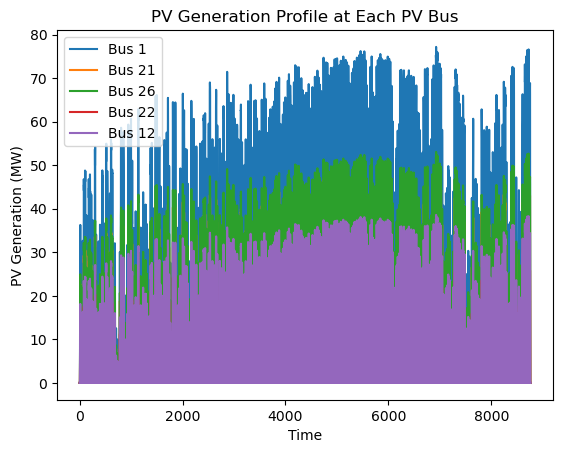

In [19]:
# Assuming the Excel file has columns corresponding to the first 5 buses for PV generation profiles
# Define the output directory and updated file path for res_sgen
output_dir = "C:/Apps-SU/My workspace/res_sgen/"
result_file_path = os.path.join(output_dir, "p_mw.xlsx")
try:
    # Load the data from p_mw.xlsx for plotting
    pv_generation_data = pd.read_excel(result_file_path, usecols="B:F")  # Load columns B to F (2nd to 6th columns)
    plt.figure()
    plt.title('PV Generation Profile at Each PV Bus')

    # Plot each bus's generation profile from the loaded data
    for i, bus in enumerate(pv_buses):
        plt.plot(pv_generation_data.iloc[:, i], label=f'Bus {bus}')  # Use column for bus

    plt.xlabel('Time')
    plt.ylabel('PV Generation (MW)')
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"File not found: {result_file_path}")

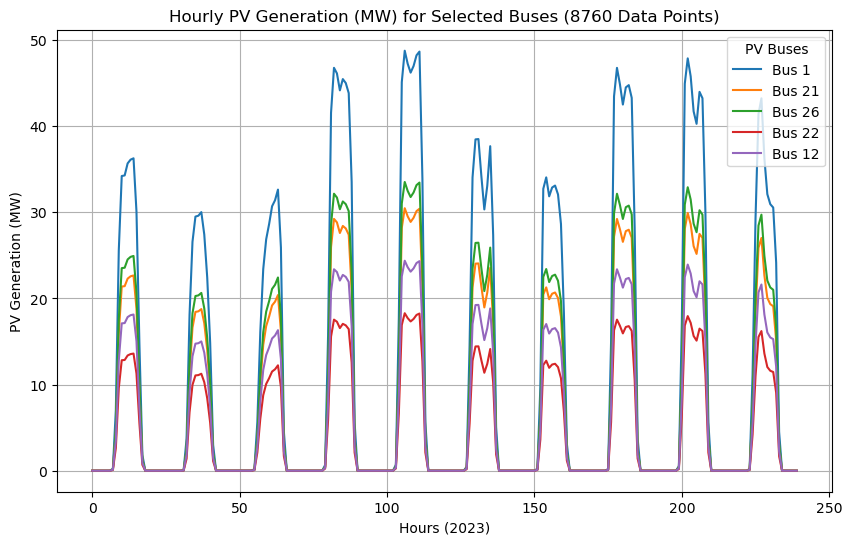

In [40]:
# Plotting the first 240 data points for each bus
plt.figure(figsize=(10, 6))
for i, bus in enumerate(pv_buses):
    plt.plot(pv_generation_data.index[:240], pv_generation_data.iloc[:240, i], label=f'Bus {bus}')

# Setting labels and title
plt.xlabel('Hours (2023)')
plt.ylabel('PV Generation (MW)')
plt.title('Hourly PV Generation (MW) for Selected Buses (8760 Data Points)')
plt.legend(title="PV Buses")
plt.grid(True)
plt.show()

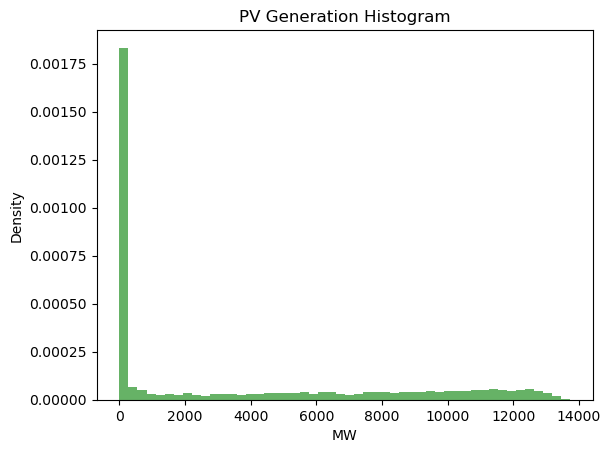

In [10]:
# Plot histogram of the data to visually inspect distribution
plt.hist(pv_generation, bins=50, density=True, alpha=0.6, color='g')
plt.title("PV Generation Histogram")
plt.xlabel("MW")
plt.ylabel("Density")
plt.show()

## Perform optimal power flow (OPF) analysis

In [11]:
pp.runopp(net)
print("OPF Results:")
print(net.res_bus)
print(net.res_line)

OPF Results:
       vm_pu  va_degree       p_mw     q_mvar     lam_p         lam_q
0   1.000000   0.000000 -39.448392  19.949940  3.577936 -4.143238e-03
1   1.004029  -0.836057 -31.402858  -5.477128  3.608594 -2.971973e-08
2   0.999105  -2.239730   2.400000   1.200000  3.671995  4.266441e-03
3   0.999526  -2.655931   7.600000   1.600000  3.689274  5.221961e-03
4   0.995485  -2.371100   0.000000  -0.188288  3.660976  1.874167e-02
5   0.995131  -2.952487   0.000000   0.000000  3.694853  2.294117e-02
6   0.985949  -3.252072  22.800000  10.900000  3.715213  3.591101e-02
7   0.983916  -3.354916  30.000000  30.000000  6.855822  3.079593e+00
8   1.012731  -3.826598   0.000000   0.000000  3.760950  4.003894e-02
9   1.022042  -4.272397   5.800000   2.000000  3.794853  4.798086e-02
10  1.012731  -3.826598   0.000000   0.000000  3.760950  4.003829e-02
11  1.044342  -4.355654  11.200000   7.500000  3.756287  1.369208e-03
12  1.099003  -3.298512 -15.125197 -43.047720  3.756254  3.822850e-04
13  1.0

 ## Monte Carlo Analysis for system reliability

In [28]:
# Calculate mean and std for each PV bus from 2023 data
pv_bus_means =  pv_generation_data.mean()
pv_bus_stds =  pv_generation_data.std()

# Print the mean and standard deviation for each PV bus
print("Mean Generation for each PV bus:\n", pv_bus_means )
print("\nStandard Deviation for each PV bus:\n", pv_bus_stds)

Mean Generation for each PV bus:
 0    20.42496
1    12.76560
2    14.04216
3     7.65936
4    10.21248
dtype: float64

Standard Deviation for each PV bus:
 0    25.622111
1    16.013819
2    17.615201
3     9.608292
4    12.811055
dtype: float64


In [32]:
# Set the number of Monte Carlo simulations
num_simulations = 5000

In [42]:
# ReLoad the ERCOT 30-bus system model
net = pn.case30()
# Initialize arrays to store results
lolp_count = 0  # Count of loss of load events
unmet_demand_hours = 0  # Total hours of unmet demand

# Add static (PV) and traditional generators to each PV bus
for i, bus in enumerate(pv_buses):
    # Traditional generator (voltage-controlled gen)
    if f"Traditional_gen_{bus}" not in net.gen['name'].values:
        pp.create_gen(net, bus, p_mw=0, vm_pu=1.00, max_p_mw=50, name=f"Traditional_gen_{bus}")
    # Photovoltaic generator as a static generator (sgen)
    if f"PV_sgen_{bus}" not in net.sgen['name'].values:
        pp.create_sgen(net, bus, p_mw=pv_bus_means[i], max_p_mw=pv_bus_means[i] + pv_bus_stds[i], name=f"PV_sgen_{bus}")
        
# Run Monte Carlo simulations
for sim in range(num_simulations):
    # Sample PV generation for each bus
    pv_samples = [np.random.normal(pv_bus_means[i], pv_bus_stds[i]) for i in range(len(pv_buses))]
    
    # Assign PV generation to static generators
    for i, bus in enumerate(pv_buses):
        pv_sgen_index = net.sgen[net.sgen['bus'] == bus].index[0]
        net.sgen.at[pv_sgen_index, 'p_mw'] = pv_samples[i]
    
    # Run power flow
    pp.runpp(net)
    
    # Check for unmet demand
    total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
    total_load = net.load['p_mw'].sum()
    
    if total_generation < total_load:
        lolp_count += 1
        unmet_demand_hours += 1

# Calculate reliability metrics
lolp = lolp_count / num_simulations
lole = lolp * num_simulations

print(f"Loss of Load Probability (LOLP): {lolp}")
print(f"Loss of Load Expectation (LOLE) over {num_simulations} hours: {lole}")

Loss of Load Probability (LOLP): 0.1382
Loss of Load Expectation (LOLE) over 5000 hours: 691.0
